In [1]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from scipy.sparse import csr_matrix
import implicit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import gdown
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor


from scipy.spatial import distance_matrix
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy import sparse

# spark imports
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, lower
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
import math  
import sklearn.metrics  
from sklearn.metrics import mean_absolute_error
import warnings

C:\Users\alfem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the ratings.dat file
ratings_df = pd.read_csv(
    r"C:\Users\alfem\Downloads\ml-1m\ml-1m\ratings.dat",
    sep='::',  # Specify the delimiter used in the .dat file
    engine='python',  # Use python engine because of custom separator
    names=['userId', 'movieId', 'rating', 'timestamp'],  # Specify column names
    encoding='ISO-8859-1'  # Use 'ISO-8859-1' encoding to handle special characters
)

# Load the movies.dat file
movies_df = pd.read_csv(
    r"C:\Users\alfem\Downloads\ml-1m\ml-1m\movies.dat",
    sep='::',  # Specify the delimiter
    engine='python',  # Use python engine for custom separator
    names=['movieId', 'title', 'genres'],  # Specify column names
    encoding='ISO-8859-1'  # Use 'ISO-8859-1' encoding to handle special characters
)


Understanding data

In [3]:
print(ratings_df.head())
print(ratings_df.shape)
print(movies_df.head())
print(movies_df.shape)

   userId  movieId  rating  timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291
(1000209, 4)
   movieId                               title                        genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
(3883, 3)


Data preprocessing

In [3]:

# Combine the resulting dataframe with movies_df on 'MovieID'
recommendation_df = pd.merge(ratings_df, movies_df, on='movieId')
recommendationwhole_df= recommendation_df
recommendation_df.drop(columns=["timestamp", "title", "genres"])



,userId,movieId,rating
0,1,1193,5
1,2,1193,5
2,12,1193,4
3,15,1193,4
4,17,1193,5
...,...,...,...
1000204,5949,2198,5
1000205,5675,2703,3
1000206,5780,2845,1
1000207,5851,3607,5


1. Alternating Least Squares



In [9]:
# Create mappings for userId and movieId to zero-based indices
user_id_mapping = {id: idx for idx, id in enumerate(recommendation_df['userId'].unique())}
movie_id_mapping = {id: idx for idx, id in enumerate(recommendation_df['movieId'].unique())}

# Initialize the ratings matrix with zeros
n_users = len(user_id_mapping)
n_items = len(movie_id_mapping)
ratings = np.zeros((n_users, n_items))

# Populate the ratings matrix using the mappings
for row in recommendation_df.itertuples():
    user_idx = user_id_mapping[row.userId]
    item_idx = movie_id_mapping[row.movieId]
    ratings[user_idx, item_idx] = row.rating

print("Shape of ratings matrix:", ratings)
# Now you can use this matrix for further analysis or model training


Shape of ratings matrix: [[5. 3. 3. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
def create_train_test(ratings):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(ratings[user]), size = 10, replace = False)

        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]
        
    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test

train, test = create_train_test(ratings)

In [11]:
class ExplicitMF:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix
    
    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm
        
    n_factors : int
        number of latent factors to use in matrix 
        factorization model, some machine-learning libraries
        denote this as rank
        
    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors  
        
    def fit(self, train, test):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))
        
        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.test_mse_record  = []
        self.train_mse_record = []   
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors) 
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)
        
        return self    
    
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_mse(y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse

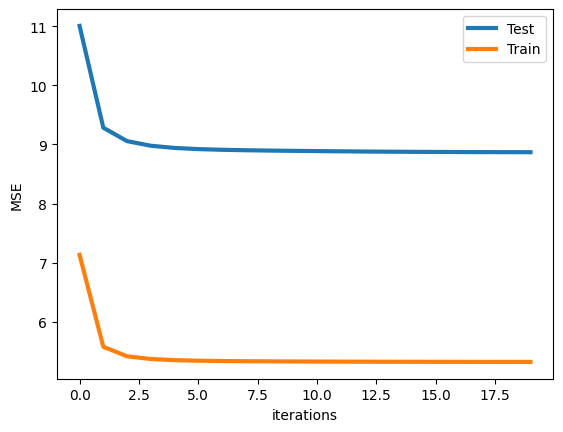

In [14]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_mse_record, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc = 'best')
als = ExplicitMF(n_iters = 20, n_factors = 40, reg = 0.01)
als.fit(train, test)
plot_learning_curve(als)

In [16]:
als.predict()[0]

array([ 9.65254469e-01,  8.99078216e-01,  9.48718397e-01, ...,
       -4.51027089e-04,  7.02540348e-03, -1.78362357e-03])

In [17]:
spark = SparkSession.builder.appName("ALSExample").getOrCreate()
recommendation_sdf = spark.createDataFrame(recommendation_df)
als = ALS(
    maxIter=5,
    regParam=0.01,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",  # This strategy drops any rows in the DataFrame of predictions that contain NaN values.
    nonnegative=True,  # Enforce non-negative predictions
    implicitPrefs=False  # Set to True if you are using implicit feedback
)
model = als.fit(recommendation_sdf)
user_recs = model.recommendForAllUsers(5)

# Show the results
user_recs.show()

recommendations_for_user_one = user_recs.filter(user_recs.userId == 1)
recommendations_for_user_one.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{2129, 8.982805}...|
+------+--------------------+



1.2) KNN collaborative filtering

1.2a) Create pivot table

In [5]:
user_ratings_pivot1 = recommendation_df.pivot(index="userId", columns = "movieId", values="rating")
user_ratings_pivot1.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#filling missing values by centralizing 
avg_ratings = user_ratings_pivot1.mean(axis = 1)
user_ratings_pivot2 = user_ratings_pivot1.sub(avg_ratings , axis = 0)
user_ratings_pivot2 = user_ratings_pivot2.fillna(0)
user_ratings_pivot2.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
userId,,,,,,,,,,,,,,,,,,,,,
1,0.811321,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.0,0.0,0.0,0.0,-1.146465,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1.2a) Create the similarity matrix

In [7]:
target_user = user_ratings_pivot2.iloc[[1]]

remove_movie_we_are_predicting = user_ratings_pivot2.drop( 1 , axis =1)

users_watched_this_movie = user_ratings_pivot1[1]
df_filled_users_watched_thismovie = user_ratings_pivot2[users_watched_this_movie.notnull()]
users_watched_this_movie.dropna(inplace = True)





In [18]:
print(target_user.head())




movieId  1     2     3     4     5     6     7     8     9     10    ...  \
userId                                                               ...   
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

movieId  3943  3944  3945  3946  3947  3948  3949  3950  3951  3952  
userId                                                               
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[1 rows x 3706 columns]


In [19]:
print(remove_movie_we_are_predicting.head())

movieId  2     3     4     5         6     7     8     9     10    11    ...  \
userId                                                                   ...   
1         0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  ...   
2         0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  ...   
3         0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  ...   
4         0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  ...   
5         0.0   0.0   0.0   0.0 -1.146465   0.0   0.0   0.0   0.0   0.0  ...   

movieId  3943  3944  3945  3946  3947  3948  3949  3950  3951  3952  
userId                                                               
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5         0.0   0.0

In [20]:

print(df_filled_users_watched_thismovie.head())

movieId      1         2     3         4     5     6         7     8     9     \
userId                                                                          
1        0.811321  0.000000   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   
6        0.098592  0.000000   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   
8        0.115108  0.000000   0.0 -0.884892   0.0   0.0  0.000000   0.0   0.0   
9        1.264151  0.000000   0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   
10       0.885287  0.885287   0.0  0.000000   0.0   0.0 -0.114713   0.0   0.0   

movieId  10    ...  3943  3944  3945  3946  3947      3948  3949  3950  3951  \
userId         ...                                                             
1         0.0  ...   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   
6         0.0  ...   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   
8         0.0  ...   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   
9         0.0  ...   0.0   0.0  

In [47]:
print(users_watched_this_movie)

userId
1       5.0
6       4.0
8       4.0
9       5.0
10      5.0
       ... 
6022    5.0
6025    5.0
6032    4.0
6035    4.0
6040    3.0
Name: 1, Length: 2077, dtype: float64


1.2c) Use the KNN

In [40]:
#cosine similarity
user_knn = KNeighborsRegressor(metric='cosine', n_neighbors=100)
user_knn.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
user_user_pred = user_knn.predict(target_user)
print(user_user_pred)

[4.21]


In [41]:
# jaccard similarity
user_knn2 = KNeighborsRegressor(metric='jaccard', n_neighbors=30)
user_knn2.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
user_user_pred2 = user_knn2.predict(target_user)
print(user_user_pred2)

[4.23333333]


C:\Users\alfem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [42]:
# euclidean distance
user_knn3 = KNeighborsRegressor(metric='euclidean', n_neighbors=30)
user_knn3.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
user_user_pred3 = user_knn3.predict(target_user)
print(user_user_pred3)

[4.46666667]


In [43]:
# manhattan distance
user_knn4 = KNeighborsRegressor(metric='manhattan', n_neighbors=30)
user_knn4.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
user_user_pred4 = user_knn4.predict(target_user)
print(user_user_pred4)

[4.33333333]


In [44]:
#find 10 points were there is a movie and not nan
#def find_not_nan(movie):
j=0
l=[]
list_columns = user_ratings_pivot1.columns
for i in user_ratings_pivot1.iloc[1]:
    if not(np.isnan(i)) :
        l.append(list_columns[j])
    j=j+1
        
print(l)

[21, 95, 110, 163, 165, 235, 265, 292, 318, 349, 356, 368, 380, 434, 442, 457, 459, 480, 498, 515, 589, 590, 593, 647, 648, 736, 780, 902, 920, 982, 1084, 1090, 1096, 1103, 1124, 1188, 1193, 1196, 1198, 1207, 1210, 1213, 1217, 1225, 1244, 1245, 1246, 1247, 1253, 1259, 1265, 1293, 1357, 1370, 1372, 1385, 1408, 1442, 1527, 1537, 1544, 1552, 1597, 1610, 1687, 1690, 1784, 1792, 1801, 1834, 1873, 1917, 1945, 1953, 1954, 1955, 1957, 1962, 1968, 2002, 2006, 2028, 2067, 2126, 2194, 2236, 2268, 2278, 2312, 2321, 2353, 2359, 2396, 2427, 2490, 2501, 2571, 2628, 2717, 2728, 2852, 2858, 2881, 2916, 2943, 3030, 3035, 3068, 3071, 3095, 3105, 3107, 3108, 3147, 3255, 3256, 3257, 3334, 3418, 3451, 3468, 3471, 3578, 3654, 3678, 3699, 3735, 3809, 3893]


In [45]:
original = []
for i in l[0:50]:
    original.append(user_ratings_pivot1.iloc[1][i])
print(original)

[1.0, 2.0, 5.0, 4.0, 3.0, 3.0, 4.0, 3.0, 5.0, 4.0, 5.0, 4.0, 5.0, 2.0, 3.0, 4.0, 3.0, 5.0, 3.0, 5.0, 4.0, 5.0, 5.0, 3.0, 4.0, 4.0, 3.0, 2.0, 5.0, 4.0, 3.0, 2.0, 4.0, 3.0, 5.0, 4.0, 5.0, 5.0, 4.0, 4.0, 4.0, 2.0, 3.0, 5.0, 3.0, 2.0, 5.0, 5.0, 3.0, 5.0]


In [46]:
def similarity(metric , list_not_empty , k):
    l = []
    for i in list_not_empty[0:50]:
        target_user = user_ratings_pivot2.iloc[[i]]
        remove_movie_we_are_predicting = user_ratings_pivot2.drop( 1 , axis =1)
        users_watched_this_movie = user_ratings_pivot1[1]
        df_filled_users_watched_thismovie = user_ratings_pivot2[users_watched_this_movie.notnull()]
        users_watched_this_movie.dropna(inplace = True)
        user_knn = KNeighborsRegressor(metric= metric , n_neighbors=k)
        user_knn.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
        user_user_pred = user_knn.predict(target_user)
        l.append(user_user_pred[0])
    return l

In [29]:
best_k= None
best_error = 2
k_results =[]
for i in range(1,21):
    #we will use cosine similarity it gives better results already
    test_cosine = similarity('cosine', l, i)
    evaluation = sklearn.metrics.mean_squared_error(original, test_cosine)
    k_results.append(evaluation)
    print("The evaluation at k = "+ str(i) + " equals to "+ str(evaluation))
    if evaluation < best_error:
        best_k = i
        best_error = evaluation

print("---------------------Final Best result at K => " + str(best_k)+ "-------------------------------")

The evaluation at k = 1 equals to 2.32
The evaluation at k = 2 equals to 1.825
The evaluation at k = 3 equals to 1.642222222222222
The evaluation at k = 4 equals to 1.5225
The evaluation at k = 5 equals to 1.4912
The evaluation at k = 6 equals to 1.4761111111111112
The evaluation at k = 7 equals to 1.4118367346938772
The evaluation at k = 8 equals to 1.3865625
The evaluation at k = 9 equals to 1.3444444444444443
The evaluation at k = 10 equals to 1.3718000000000001
The evaluation at k = 11 equals to 1.3942148760330582
The evaluation at k = 12 equals to 1.3633333333333335
The evaluation at k = 13 equals to 1.3927810650887578
The evaluation at k = 14 equals to 1.3670408163265302
The evaluation at k = 15 equals to 1.3753777777777778
The evaluation at k = 16 equals to 1.352578125
The evaluation at k = 17 equals to 1.3874048442906577
The evaluation at k = 18 equals to 1.3977160493827159
The evaluation at k = 19 equals to 1.388310249307479
The evaluation at k = 20 equals to 1.380750000000000

In [30]:
test_cosine = similarity('cosine', l, best_k)
test_jaccard = similarity('jaccard', l, best_k)
test_euclidean = similarity('euclidean', l, best_k)
test_manhattan = similarity('manhattan', l, best_k)

C:\Users\alfem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\alfem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\alfem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\alfem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sk

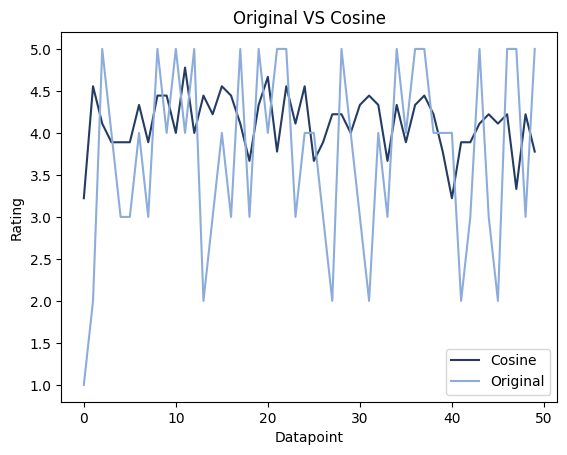

In [31]:
plt.plot(test_cosine, label = "Cosine",color="#243c63")
plt.plot(original, label = "Original", color ='#8cacdc')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Cosine')
plt.show()

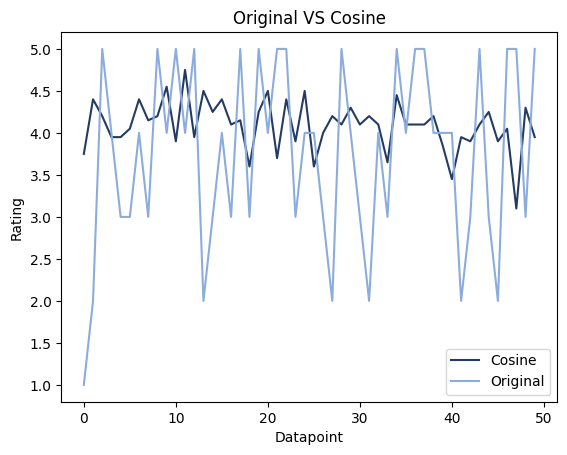

In [32]:
test_cosine1 = similarity('cosine', l, 20)
plt.plot(test_cosine1, label = "Cosine",color="#243c63")
plt.plot(original, label = "Original", color ='#8cacdc')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Cosine')
plt.show()

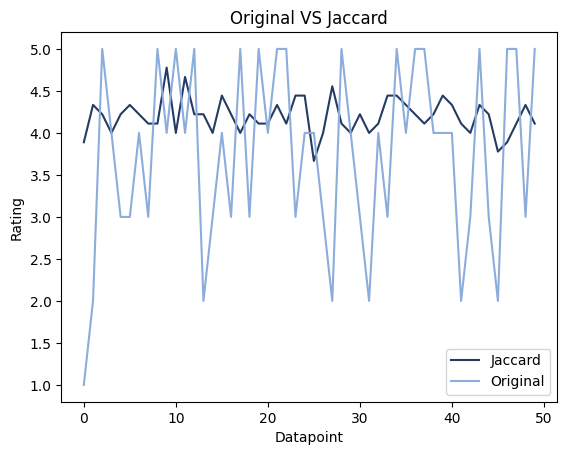

In [34]:
plt.plot(test_jaccard, label = "Jaccard",color="#243c63")
plt.plot(original, label = "Original", color ='#8cacdc')
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Jaccard')
plt.legend()
plt.show()

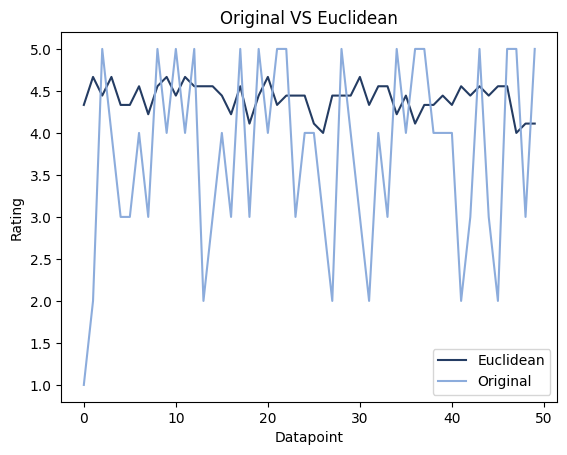

In [35]:
plt.plot(test_euclidean, label = "Euclidean",color="#243c63")
plt.plot(original, label = "Original", color ='#8cacdc')
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Euclidean')
plt.legend()
plt.show()

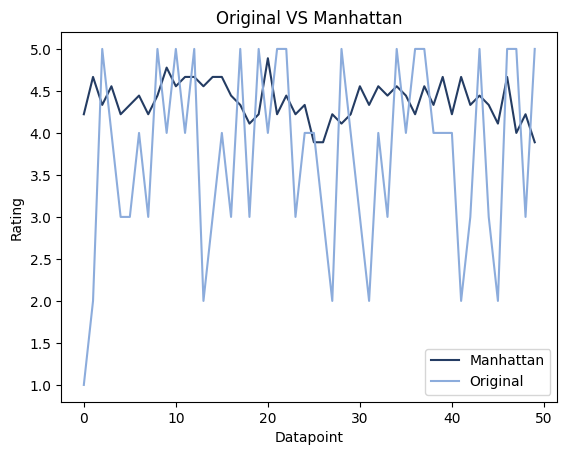

In [36]:
plt.plot(test_manhattan, label = "Manhattan",color="#243c63")
plt.plot(original, label = "Original", color ='#8cacdc')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Manhattan')
plt.show()

EVALUATION

In [37]:
e_cosine =[sklearn.metrics.mean_squared_error(original, test_cosine), mean_absolute_error(original,test_cosine)]
e_jaccard=[sklearn.metrics.mean_squared_error(original, test_jaccard), mean_absolute_error(original,test_jaccard)]
e_euclidean=[sklearn.metrics.mean_squared_error(original, test_euclidean), mean_absolute_error(original,test_euclidean)]
e_manhattan =[sklearn.metrics.mean_squared_error(original, test_manhattan), mean_absolute_error(original,test_manhattan)]
evaluation_df = pd.DataFrame( {
                "Cosine similarity" : e_cosine,
                "Jaccard similarity": e_jaccard,
                "Euclidean similarity": e_euclidean,
                "Manhattan similarity": e_manhattan,
                "SVD" : [0.8744 , 0.6756]},
                index=['RMSE', 'MAE']
)

evaluation_df

,Cosine similarity,Jaccard similarity,Euclidean similarity,Manhattan similarity,SVD
RMSE,1.344444,1.403704,1.666914,1.604444,0.8744
MAE,0.971111,0.993333,1.051111,1.040000,0.6756


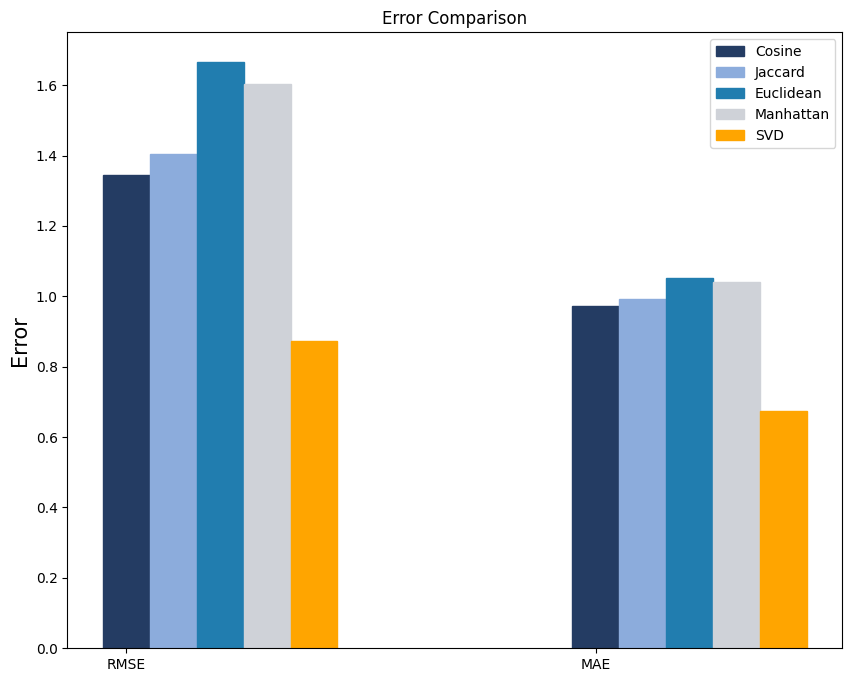

In [39]:
# set width of bar
barWidth = 0.1
fig = plt.subplots(figsize =(10, 8))

# Set position of bar on X axis
br1 = np.arange(len(e_cosine))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

# Make the plot
plt.bar(br2, e_cosine, color ='#243c63', width = barWidth,
		edgecolor ='#243c63', label ='Cosine')
plt.bar(br3, e_jaccard, color ='#8cacdc', width = barWidth,
		edgecolor ='#8cacdc', label ='Jaccard')
plt.bar(br4, e_euclidean, color ='#217daf', width = barWidth,
		edgecolor ='#217daf', label ='Euclidean')
plt.bar(br5, e_manhattan, color ='#cfd2d8', width = barWidth,
		edgecolor ='#cfd2d8', label ='Manhattan')
plt.bar(br6, [0.8744 , 0.6756], color ='orange', width = barWidth,
		edgecolor ='orange', label ='SVD')

# Adding Xticks
plt.ylabel('Error', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(e_cosine))],
		['RMSE' , 'MAE'])

plt.title('Error Comparison')
plt.legend()
plt.show()

In [50]:
# Find unrated movies for the target user
target_user_id = 1
unrated_movies = user_ratings_pivot1.loc[target_user_id][user_ratings_pivot1.loc[target_user_id].isna()].index

# Predict ratings for unrated movies
predicted_ratings = {}

for movie in unrated_movies:
    # Prepare the input data (exclude the movie we are predicting)
    target_user = user_ratings_pivot2.iloc[[target_user_id]].drop(columns=movie, errors='ignore')  # Exclude the movie
    df_filled_users_watched_thismovie = user_ratings_pivot2.drop(movie, axis=1)

    # Filter users who watched this movie
    movie_ratings = user_ratings_pivot1[movie]
    df_filled_users_watched_thismovie = df_filled_users_watched_thismovie[movie_ratings.notnull()]
    movie_ratings = movie_ratings.dropna()

    # Check if the number of samples is less than n_neighbors and adjust
    num_samples = df_filled_users_watched_thismovie.shape[0]
    n_neighbors = min(best_k, num_samples)  # Ensure n_neighbors <= num_samples

    if num_samples < 1:
        continue  # Skip if there are no samples to fit the model

    # Fit the KNN model with the adjusted n_neighbors
    user_knn = KNeighborsRegressor(metric='cosine', n_neighbors=n_neighbors)
    user_knn.fit(df_filled_users_watched_thismovie, movie_ratings)

    # Ensure the dimensions of `target_user` and `df_filled_users_watched_thismovie` match
    predicted_rating = user_knn.predict(target_user)
    predicted_ratings[movie] = predicted_rating[0]

# Sort the predicted ratings in descending order
sorted_predictions = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)

# Get the top N movie recommendations
top_n = 5  # Choose how many movies you want to recommend
recommended_movies = sorted_predictions[:top_n]

# Print out the recommended movie IDs and their predicted ratings
for movie_id, rating in recommended_movies:
    print(f"Recommended MovieID: {movie_id}, Predicted Rating: {rating}")

Recommended MovieID: 787, Predicted Rating: 5.0
Recommended MovieID: 989, Predicted Rating: 5.0
Recommended MovieID: 1830, Predicted Rating: 5.0
Recommended MovieID: 3172, Predicted Rating: 5.0
Recommended MovieID: 3233, Predicted Rating: 5.0
